In [ ]:
'''
利用马尔可夫聚类
熊毅
2016011467
'''

### 数据载入

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
import pandas as pd

iris = datasets.load_iris()


iris1 = pd.DataFrame(iris.data)
iris1['target'] = iris.target
iris1.columns = ['1',
 '2',
 '3',
 '4','y']
iris1['yp']=0   #预测列

### 马尔可夫—邻接矩阵收敛

In [10]:
adjacent_matrix = np.zeros((150,150))

for i,v in iris1.iterrows():     #邻接矩阵
    for i1,v1 in iris1.iterrows():
        distance = 0
        for i2 in range(4):
            distance += np.square(v[i2]-v1[i2])
        adjacent_matrix[i][i1] = np.sqrt(distance)
      
        
mat = adjacent_matrix            #马尔可夫链
def mat_normalizer(mat,expa):  
    for i1 in range(expa):
        mat = np.matmul(mat,adjacent_matrix)
        mat = mat**5               #膨胀系数设为5
        for i,v in enumerate(mat):
            sum_dis = sum(v)
            for i1 in range(150):
                v[i1] = v[i1]/sum_dis  #归一化
    return mat
mat = mat_normalizer(mat,20)    #结果
mat

array([[3.63717615e-07, 6.88782034e-07, 5.58805740e-07, ...,
        9.38692955e-03, 1.15567214e-02, 6.32633940e-03],
       [3.63717615e-07, 6.88782034e-07, 5.58805740e-07, ...,
        9.38692955e-03, 1.15567214e-02, 6.32633940e-03],
       [3.63717615e-07, 6.88782034e-07, 5.58805740e-07, ...,
        9.38692955e-03, 1.15567214e-02, 6.32633940e-03],
       ...,
       [1.94461855e-02, 2.03770325e-02, 2.38708858e-02, ...,
        1.15520409e-05, 2.13353161e-05, 3.90621235e-05],
       [1.94461855e-02, 2.03770325e-02, 2.38708858e-02, ...,
        1.15520409e-05, 2.13353161e-05, 3.90621235e-05],
       [1.94461855e-02, 2.03770325e-02, 2.38708858e-02, ...,
        1.15520409e-05, 2.13353161e-05, 3.90621235e-05]])

### 分类 

In [14]:
#遍历每个样本，投票
vote_matrix = np.zeros((150,150))  #每一行记录着结果矩阵中距离此点0.0001以内的点，并将节点记为1

for i,v in enumerate(mat):
    for i1,v1 in enumerate(v):
        if v1<1/10000:
            vote_matrix[i,i1]=1



def vote():      
    one_time = 0    #临近点的分类信息
    two_time = 0
    thr_time = 0
    clas_mom = 1
    new_class = 1
    for i in range(150):
        if sum(vote_matrix[:,i])>=45:     #有超过45个邻近点的点
            for i1,v1 in enumerate(vote_matrix[:,i]):     #统计该点的临近点已有的分类信息
                if v1 == 1:
                    if iris1.iloc[i1][5] == 1:
                        one_time+=1
                    elif iris1.iloc[i1][5] == 2:
                        two_time+=1
                    elif iris1.iloc[i1][5] == 3:
                        thr_time +=1
#            print(one_time,two_time,thr_time)
            if one_time > 35:                #若临近点有超过35个点属于第一类，则将该点的所有临近点标记为第一类
                clas_mom =1
            elif two_time >35:
                clas_mom =2
            elif thr_time >35:
                clas_mom =3
            elif (one_time+two_time+thr_time)<20:       #若该点的临近点标类总数少于20，则将该点的临近点标为一类
                clas_mom = new_class
                new_class +=1
            else :
                clas_mom = 0
            if clas_mom != 0:
                for i2,v2 in enumerate(vote_matrix[:,i]):
                    if v2 ==1:
                        iris1.iloc[i2,5] = clas_mom    #iris.iloc[i2][5]将视为一个深拷贝,无法改变其值
        one_time = 0
        two_time = 0
        thr_time = 0

vote()           
    
def acc():
    sum_righ = 0
    for i,v in iris1.iloc[:,[4,5]].iterrows():
        if v[0] == (v[1]-1):
            sum_righ +=1
    return sum_righ/150

print(acc())

0.6333333333333333


#### 结果中第二类的计算结果不理想，导致了误差

### 画图  原分类 

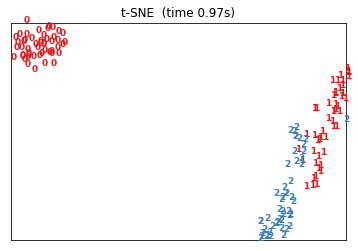

In [12]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.manifold import TSNE


def get_data():
    digits = datasets.load_digits(n_class=6)
    data = digits.data
    label = digits.target
    n_samples, n_features = data.shape
    return data, label, n_samples, n_features


def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)

    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig




tsne = TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
result = tsne.fit_transform(iris.data)
fig = plot_embedding(result, iris.target,
                     't-SNE  (time %.2fs)'
                     % (time() - t0))
plt.show(fig)

###  根据结果矩阵

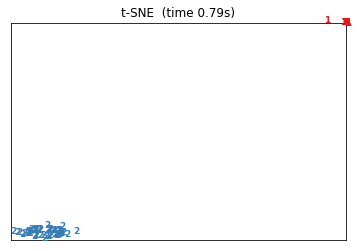

In [15]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
result = tsne.fit_transform(mat)
fig = plot_embedding(result, iris1['yp'],
                     't-SNE  (time %.2fs)'
                     % (time() - t0))
plt.show(fig)